In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
n_train = len(train)
n_pixels = len(train.columns) - 1
n_class = len(set(train['label']))

print("Number of training samples:", n_train)
print("Number of pixels per sample:", n_pixels)
print("Number of class:", n_class)

Number of training samples: 42000
Number of pixels per sample: 784
Number of class: 10


In [68]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
n_test = len(test)
n_pixels = len(test.columns)
print("Number of test samples:", n_test)

Number of test samples: 28000


5, 4, 1, 9, 3, 8, 3, 9


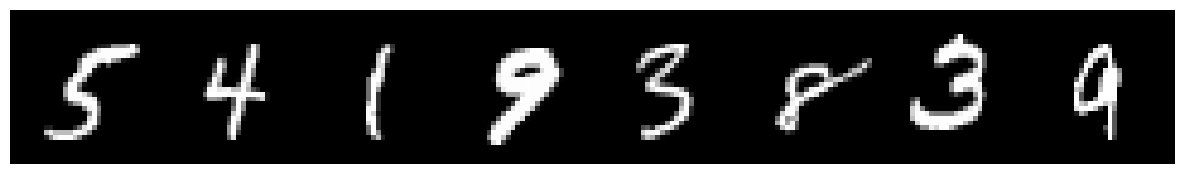

In [69]:
random_sel = np.random.randint(n_train, size=8)
imgs= torch.Tensor(train.iloc[random_sel, 1:].values/255).reshape(-1, 28, 28).unsqueeze(1)
grid = make_grid(imgs, nrow=8)
plt.rcParams["figure.figsize"] = (16, 2)
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis("off")
labels = train.iloc[random_sel, 0].values
print(*list(labels), sep=", ")

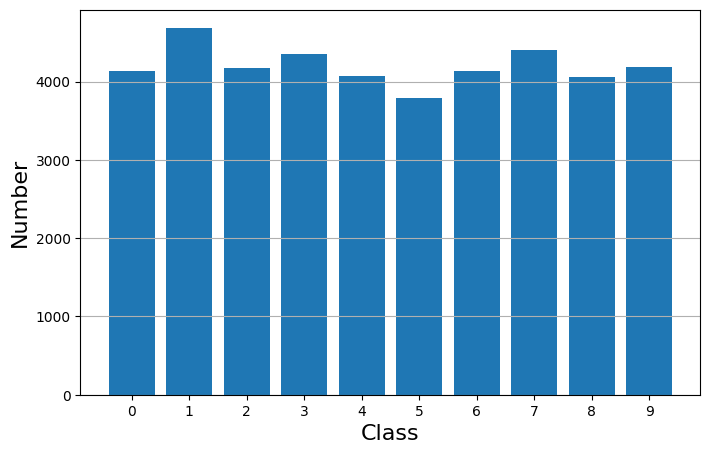

In [70]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train["label"].value_counts().index, train["label"].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number", fontsize=16)
plt.grid("on", axis='y')

In [71]:
class Mnist_data(Dataset):
    def __init__(self, file_path, transform = transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])):
        df = pd.read_csv(file_path)

        # test dataset
        if len(df.columns) == n_pixels:
            self.x = df.values.reshape(-1, 28, 28).astype(np.uint8)[:,:,:,None]
            self.y = None
        # train dataset
        else:
            self.x = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)

        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.transform(self.x[idx])
        else:
            return self.transform(self.x[idx]), self.y[idx]


In [72]:
class RandomRotation(object):
    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be a positive number")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degress is a sequence, it must be len 2")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        return np.random.uniform(degrees[0], degrees[1])

    def __call__(self, img):
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)
        return rotate(img, angle, self.resample, self.expand, self.center)

In [73]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift

    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)
        return hshift, vshift

    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift))

In [74]:
batch_size = 64
train_dataset = Mnist_data("/kaggle/input/digit-recognizer/train.csv", 
                           transform = transforms.Compose([
                           transforms.ToPILImage(),
                           RandomRotation(degrees=45),
                           RandomShift(shift=3),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = Mnist_data("/kaggle/input/digit-recognizer/test.csv")

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size=batch_size, shuffle=False)

/tmp/ipykernel_35/1682266140.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


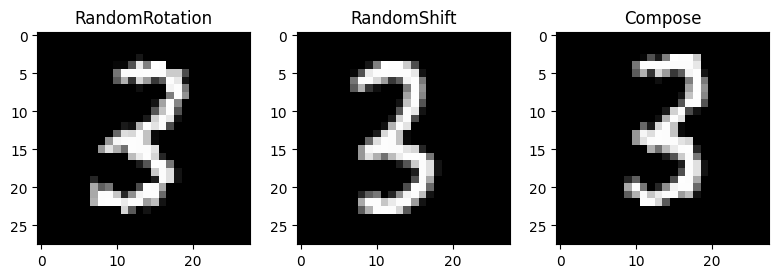

In [75]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20), RandomShift(3)])

fig = plt.figure()
sample = transforms.ToPILImage()(train.iloc[65, 1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfm(sample)
    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')

plt.show()

In [76]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64*7*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10)
        )

        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                # he kaiming normal initialization
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0/n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.reshape((x.shape[0], -1))
        x = self.classifier(x)
        return x

In [77]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [78]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item())))

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():  # 替代 Variable + volatile
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum')  # 求总损失
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)  # 获取预测类别
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)

    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [80]:
n_epochs = 10

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader, device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Epoch: 0 [6400/42000 (15%)]	Loss: 1.181412
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.590747
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.552554
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.377360
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.299351
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.323537

Average loss: 0.1720, Accuracy: 39739/42000 (94.617%)

Train Epoch: 1 [6400/42000 (15%)]	Loss: 0.138373
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.235876
Train Epoch: 1 [19200/42000 (46%)]	Loss: 0.167197
Train Epoch: 1 [25600/42000 (61%)]	Loss: 0.222009
Train Epoch: 1 [32000/42000 (76%)]	Loss: 0.104129
Train Epoch: 1 [38400/42000 (91%)]	Loss: 0.109855

Average loss: 0.1098, Accuracy: 40581/42000 (96.621%)

Train Epoch: 2 [6400/42000 (15%)]	Loss: 0.165451
Train Epoch: 2 [12800/42000 (30%)]	Loss: 0.213921
Train Epoch: 2 [19200/42000 (46%)]	Loss: 0.121456
Train Epoch: 2 [25600/42000 (61%)]	Loss: 0.086101
Train Epoch: 2 [32000/42000 (76%)]	Loss: 0.061548
Train Epoch: 2 [38400/42000 (91%)]	Loss: 

In [81]:
def prediciton(data_loader, device):
    model.eval()
    test_pred = []

    with torch.no_grad():  # 替代 volatile
        for data in data_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_pred.append(pred.cpu())

    return torch.cat(test_pred, dim=0)

In [82]:
test_pred = prediciton(test_loader, device)

In [83]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [84]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [85]:
out_df.to_csv('submission.csv', index=False)